### 导入数据

In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# # 新数据
# # 读取所有数据
# paths = [
#     # '../data/processed_data_900_1.csv', '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
#     # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
#     # '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
#     # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
#     # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
#     # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
#     # '../data/new/processed_data_1500_1.csv', '../data/new/processed_data_1500_2.csv', '../data/new/processed_data_1500_3.csv',
#     # '../data/new/processed_data_1500_4.csv', '../data/new/processed_data_1500_5.csv', '../data/new/processed_data_1500_6.csv'
#     '../data/clean/clean_processed_data_1500_1.csv', '../data/clean/clean_processed_data_1500_2.csv', '../data/clean/clean_processed_data_1500_3.csv',
#     '../data/clean/clean_processed_data_1500_4.csv', '../data/clean/clean_processed_data_1500_5.csv', '../data/clean/clean_processed_data_1500_6.csv'
# ]

# # 读取并拼接数据
# # all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
# # all_data = np.array(all_data)
# # all_data.shape

In [ ]:
# all_data = []
# for path in paths:
#     data = pd.read_csv(path)
#     data = np.array(data)
#     all_data.append(data)
# all_data = np.concatenate(all_data, axis=0)

In [ ]:
# # 处理数据的函数
# def process_data(data):
#     pro_data = []
#     for record in data:
#         # 每条记录是一个字符串，将其按分号分割
#         elements = record[0].split(';')
#         processed_data = []
#         for element in elements:
#             # print(element)
#             # 去除括号并按逗号分割成元素和数字
#             mol, count = element.strip('()').split(',')
#             processed_data.append((mol, int(count)))
#         pro_data.append(np.array(processed_data))
#     return pro_data

# # 调用函数处理数据
# processed = process_data(all_data)
# processed = np.array(processed)
# print(processed.shape)

NameError: name 'all_data' is not defined

In [2]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 加载 .npy 文件
new_processed = np.load('../data/new_processed20.npy', allow_pickle=True)
print(new_processed.shape)

(2652,)


In [4]:
new_processed[0].shape

(41, 2)

### Embedding

In [5]:
# incode 编码，转换成向量
import numpy as np
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [6]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = new_processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
# cy_data = [[incode(value[0]) for value in row] for row in cy_data]
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_35012\2105827966.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(2652,)

In [7]:
# 找到cy——data中的最大值
max_num = 0
for row in cy_data:
    for value in row:
        if value[3] > max_num:
            max_num = value[3]
max_num

19395

In [8]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    # print(sequence.shape)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (2652,)
X.shape (2652,)
y.shape (2652,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_35012\952688469.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_35012\952688469.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_35012\952688469.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

In [9]:
print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状
print('X[0].shape', X[0].shape)  # 输入的形状
print('y[0].shape', y[0].shape)  # 输出的形状

X.shape (2652,)
y.shape (2652,)
X[0].shape (30, 10, 4)
y[0].shape (30, 4)


In [ ]:
# X_concat = np.concatenate(X)
# X_concat = X_concat.reshape(-1, 10, 4)
# y_concat = np.concatenate(y)

# print('X.shape', X_concat.shape)# X_train.shape (1035, 2899, 100, 3)
# print('y.shape', y_concat.shape)# X_test.shape (691, 2899, 100, 3)

X.shape (91670, 10, 4)
y.shape (91670, 4)


In [ ]:
# # 找到 y 中第四个特征大于 10000 的索引
# filter_condition = y_concat[:, 3] <= 8000

# # 根据索引筛选 X 和 y
# X_filtered = X_concat[filter_condition]
# y_filtered = y_concat[filter_condition]

# # 查看结果
# print(X_filtered.shape)
# print(y_filtered.shape)

(91439, 10, 4)
(91439, 4)


### 重采样

#### 先重采样


In [60]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 获取第四个特征
y_feature4 = y_filtered[:, 3]

# 设定分桶数（可以调整）
num_bins = 10
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_filtered))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（取最大桶的样本数量）
target_samples = bin_counts.max()

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    # 过采样到目标样本数
    sampled = np.random.choice(bin_indices, target_samples, replace=True)
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_resampled = X_filtered[resampled_indices]
y_resampled = y_filtered[resampled_indices]

print(f"重采样后的X.shape: {X_resampled.shape}")
print(f"重采样后的y.shape: {y_resampled.shape}")


重采样后的X.shape: (733359, 10, 4)
重采样后的y.shape: (733359, 4)


In [44]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 获取第四个特征
y_feature4 = y_filtered[:, 3]

# 设定分桶数（可以调整）
num_bins = 10
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_filtered))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（可以选择均衡化）
# target_samples = bin_counts.median()  # 目标数量取中位数
# 选择目标样本数（取最大桶的样本数量）
target_samples = bin_counts.max()

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    if count > target_samples:
        # 欠采样
        sampled = np.random.choice(bin_indices, int(target_samples), replace=False)
    else:
        # 过采样
        sampled = np.random.choice(bin_indices, int(target_samples), replace=True)
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_resampled = X_filtered[resampled_indices]
y_resampled = y_filtered[resampled_indices]

print(f"重采样后的X.shape: {X_resampled.shape}")
print(f"重采样后的y.shape: {y_resampled.shape}")


重采样后的X.shape: (733359, 10, 4)
重采样后的y.shape: (733359, 4)


In [60]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 获取第四个特征
y_feature4 = y_concat[:, 3]

# 设定分桶数（可以调整）
num_bins = 10
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_concat))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（取最大桶的样本数量）
target_samples = bin_counts.max()

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    # 过采样到目标样本数
    sampled = np.random.choice(bin_indices, target_samples, replace=True)
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_resampled = X_concat[resampled_indices]
y_resampled = y_concat[resampled_indices]

print(f"重采样后的X.shape: {X_resampled.shape}")
print(f"重采样后的y.shape: {y_resampled.shape}")


重采样后的X.shape: (876942, 10, 4)
重采样后的y.shape: (876942, 4)


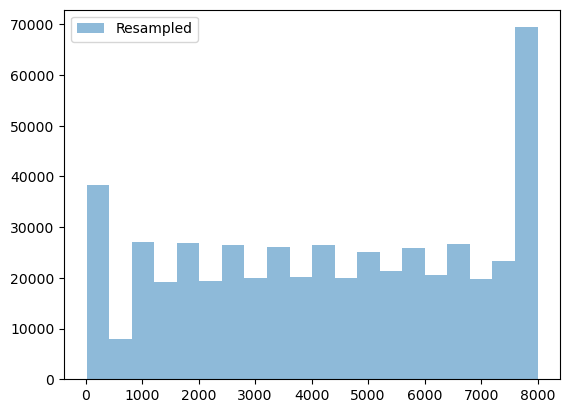

In [61]:
import matplotlib.pyplot as plt

# plt.hist(y_concat[:, 3], bins=20, alpha=0.5, label="Original")
plt.hist(y_train_resampled[:, 3], bins=20, alpha=0.5, label="Resampled")
plt.legend()
plt.show()

In [9]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (513351, 10, 4)
X_test.shape (220008, 10, 4)
y_train.shape (513351, 4)
y_test.shape (220008, 4)


#### 先分训练集和测试集

In [8]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (1856,)
X_test.shape (796,)
y_train.shape (1856,)
y_test.shape (796,)


max(y_train)

In [11]:
X_train.shape

(1856,)

In [9]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (63858, 10, 4)
X_test.shape (27812, 10, 4)
y_train.shape (63858, 4)
y_test.shape (27812, 4)


In [10]:
# 创建掩码，筛选第四个特征 <= num 的样本
num = 8000
mask_train = y_train[:, 3] <= num

# 应用掩码到X_train和y_train
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# 创建掩码，筛选第四个特征 <= num 的样本
mask_test = y_test[:, 3] <= num

# 应用掩码到X_test和y_test
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print("处理后的形状:")
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

处理后的形状:
X_train.shape (63691, 10, 4)
y_train.shape (63691, 4)
X_test.shape (27748, 10, 4)
y_test.shape (27748, 4)


In [56]:
int(np.median(bin_counts))

779

In [11]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 获取第四个特征
y_feature4 = y_train[:, 3]

# 设定分桶数（可以调整）
num_bins = 20
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_train))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（目标样本数取每个桶的中位数）
target_samples = 2000 # int(np.median(bin_counts))

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    if count > target_samples:
        # 如果该桶的样本数量大于目标样本数，进行欠采样
        sampled = np.random.choice(bin_indices, target_samples, replace=False)
    else:
        # 如果该桶的样本数量小于或等于目标样本数，保持不变
        sampled = bin_indices
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_train_resampled = X_train[resampled_indices]
y_train_resampled = y_train[resampled_indices]

print(f"重采样后的X.shape: {X_train_resampled.shape}")
print(f"重采样后的y.shape: {y_train_resampled.shape}")


# 获取第四个特征
y_feature4 = y_test[:, 3]

# 设定分桶数（可以调整）
num_bins = 20
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_test))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（目标样本数取每个桶的中位数）
target_samples =  800 # int(np.median(bin_counts))

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    if count > target_samples:
        # 如果该桶的样本数量大于目标样本数，进行欠采样
        sampled = np.random.choice(bin_indices, target_samples, replace=False)
    else:
        # 如果该桶的样本数量小于或等于目标样本数，保持不变
        sampled = bin_indices
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_test_resampled = X_test[resampled_indices]
y_test_resampled = y_test[resampled_indices]

print(f"重采样后的X.shape: {X_test_resampled.shape}")
print(f"重采样后的y.shape: {y_test_resampled.shape}")

重采样后的X.shape: (17101, 10, 4)
重采样后的y.shape: (17101, 4)
重采样后的X.shape: (7102, 10, 4)
重采样后的y.shape: (7102, 4)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import resample

# # 获取第四个特征
# y_feature4 = y_test[:, 3]

# # 设定分桶数（可以调整）
# num_bins = 10
# bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
# bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# # 创建DataFrame便于处理
# df = pd.DataFrame({'bin': bin_labels})
# df['index'] = np.arange(len(y_test))

# # 计算每个桶的样本数
# bin_counts = df['bin'].value_counts()

# # 选择目标样本数（取最大桶的样本数量）
# target_samples = bin_counts.max()

# resampled_indices = []

# for bin_label, count in bin_counts.items():
#     bin_indices = df[df['bin'] == bin_label]['index'].values
    
#     # 过采样到目标样本数
#     sampled = np.random.choice(bin_indices, target_samples, replace=True)
    
#     resampled_indices.extend(sampled)

# # 获取新的数据集
# X_test_resampled = X_test[resampled_indices]
# y_test_resampled = y_test[resampled_indices]

# print(f"重采样后的X.shape: {X_test_resampled.shape}")
# print(f"重采样后的y.shape: {y_test_resampled.shape}")


重采样后的X.shape: (223135, 10, 4)
重采样后的y.shape: (223135, 4)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import resample

# # 获取第四个特征
# y_feature4 = y_train[:, 3]

# # 设定分桶数（可以调整）
# num_bins = 10
# bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
# bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# # 创建DataFrame便于处理
# df = pd.DataFrame({'bin': bin_labels})
# df['index'] = np.arange(len(y_train))

# # 计算每个桶的样本数
# bin_counts = df['bin'].value_counts()

# # 选择目标样本数（可以选择均衡化）
# # target_samples = bin_counts.median()  # 目标数量取中位数
# # 选择目标样本数（取最大桶的样本数量）
# target_samples = bin_counts.max()

# resampled_indices = []

# for bin_label, count in bin_counts.items():
#     bin_indices = df[df['bin'] == bin_label]['index'].values
    
#     if count > target_samples:
#         # 欠采样
#         sampled = np.random.choice(bin_indices, int(target_samples), replace=False)
#     else:
#         # 过采样
#         sampled = np.random.choice(bin_indices, int(target_samples), replace=True)
    
#     resampled_indices.extend(sampled)

# # 获取新的数据集
# X_train_resampled = X_train[resampled_indices]
# y_train_resampled = y_train[resampled_indices]

# print(f"重采样后的X.shape: {X_train_resampled.shape}")
# print(f"重采样后的y.shape: {y_train_resampled.shape}")

重采样后的X.shape: (510224, 10, 4)
重采样后的y.shape: (510224, 4)


In [12]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 获取第四个特征
y_feature4 = y_test[:, 3]

# 设定分桶数（可以调整）
num_bins = 10
bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# 创建DataFrame便于处理
df = pd.DataFrame({'bin': bin_labels})
df['index'] = np.arange(len(y_test))

# 计算每个桶的样本数
bin_counts = df['bin'].value_counts()

# 选择目标样本数（可以选择均衡化）
# target_samples = bin_counts.median()  # 目标数量取中位数
# 选择目标样本数（取最大桶的样本数量）
target_samples = bin_counts.max()

resampled_indices = []

for bin_label, count in bin_counts.items():
    bin_indices = df[df['bin'] == bin_label]['index'].values
    
    if count > target_samples:
        # 欠采样
        sampled = np.random.choice(bin_indices, int(target_samples), replace=False)
    else:
        # 过采样
        sampled = np.random.choice(bin_indices, int(target_samples), replace=True)
    
    resampled_indices.extend(sampled)

# 获取新的数据集
X_test_resampled = X_test[resampled_indices]
y_test_resampled = y_test[resampled_indices]

print(f"重采样后的X.shape: {X_test_resampled.shape}")
print(f"重采样后的y.shape: {y_test_resampled.shape}")

重采样后的X.shape: (223135, 10, 4)
重采样后的y.shape: (223135, 4)


In [ ]:
# import numpy as np
# import pandas as pd

# def resample_by_target(X, y, n_bins=10, strategy="undersample"):
#     """
#     对数据集 (X, y) 进行基于 y[:, 3] 的均匀重采样
#     参数：
#         X: (N, 10, 4) 训练或测试数据
#         y: (N, 4)  目标标签
#         n_bins: 分桶的数量，默认 10
#         strategy: 采样策略，"undersample" 进行下采样，"oversample" 进行上采样
#     返回：
#         X_resampled, y_resampled: 重新采样后的数据
#     """
#     # 获取 y[:, 3] 作为分桶依据
#     y_feature = y[:, 3]
    
#     # 使用 pd.qcut 进行等频分桶
#     bins, bin_edges = pd.qcut(y_feature, q=n_bins, retbins=True, labels=False, duplicates="drop")
    
#     # 统计每个桶的样本数
#     bin_counts = np.bincount(bins)
    
#     # 选择采样的目标数量
#     if strategy == "undersample":
#         target_size = bin_counts.min()  # 选择最小桶数量进行下采样
#     elif strategy == "oversample":
#         target_size = bin_counts.max()  # 选择最大桶数量进行上采样
#     else:
#         raise ValueError("strategy 只能是 'undersample' 或 'oversample'")
    
#     # 存储采样后的索引
#     sampled_indices = []
    
#     # 遍历每个桶并进行采样
#     for bin_id in range(len(bin_counts)):
#         indices = np.where(bins == bin_id)[0]  # 获取该桶的索引
        
#         if len(indices) > target_size:
#             sampled_bin = np.random.choice(indices, target_size, replace=True)  # 下采样
#         else:
#             sampled_bin = np.random.choice(indices, target_size, replace=True)  # 上采样
            
#         sampled_indices.extend(sampled_bin)
    
#     # 打乱索引
#     np.random.shuffle(sampled_indices)
    
#     # 生成重采样后的数据
#     X_resampled = X[sampled_indices]
#     y_resampled = y[sampled_indices]
    
#     return X_resampled, y_resampled

# # 对训练集和测试集分别进行重采样
# X_train_resampled, y_train_resampled = resample_by_target(X_train, y_train, n_bins=10, strategy="undersample")
# X_test_resampled, y_test_resampled = resample_by_target(X_test, y_test, n_bins=10, strategy="undersample")

# # 保存结果
# np.save("X_train_resampled.npy", X_train_resampled)
# np.save("y_train_resampled.npy", y_train_resampled)
# np.save("X_test_resampled.npy", X_test_resampled)
# np.save("y_test_resampled.npy", y_test_resampled)

# # 打印数据变化情况
# print("Resampled X_train shape:", X_train_resampled.shape)
# print("Resampled y_train shape:", y_train_resampled.shape)
# print("Resampled X_test shape:", X_test_resampled.shape)
# print("Resampled y_test shape:", y_test_resampled.shape)

Resampled X_train shape: (61560, 10, 4)
Resampled y_train shape: (61560, 4)
Resampled X_test shape: (27190, 10, 4)
Resampled y_test shape: (27190, 4)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import resample

# # 获取第四个特征
# y_feature4 = y_train[:, 3]

# # 设定分桶数（可以调整）
# num_bins = 10
# bins = np.linspace(y_feature4.min(), y_feature4.max(), num_bins + 1)
# bin_labels = np.digitize(y_feature4, bins)  # 将数据分配到不同的桶

# # 创建DataFrame便于处理
# df = pd.DataFrame({'bin': bin_labels})
# df['index'] = np.arange(len(y_train))

# # 计算每个桶的样本数
# bin_counts = df['bin'].value_counts()

# # 选择目标样本数（取最小桶的样本数量）
# # target_samples = bin_counts.min()
# target_samples = bin_counts.median()  # 目标数量取中位数


# resampled_indices = []

# for bin_label, count in bin_counts.items():
#     bin_indices = df[df['bin'] == bin_label]['index'].values
    
#     # 欠采样到目标样本数（如果样本多于目标数量）
#     if count > target_samples:
#         sampled = np.random.choice(bin_indices, target_samples, replace=False)
#     else:
#         sampled = bin_indices
    
#     resampled_indices.extend(sampled)

# # 获取新的数据集
# X_train_resampled = X_train[resampled_indices]
# y_train_resampled = y_train[resampled_indices]

# print(f"重采样后的X.shape: {X_train_resampled.shape}")
# print(f"重采样后的y.shape: {y_train_resampled.shape}")

TypeError: 'numpy.float64' object cannot be interpreted as an integer

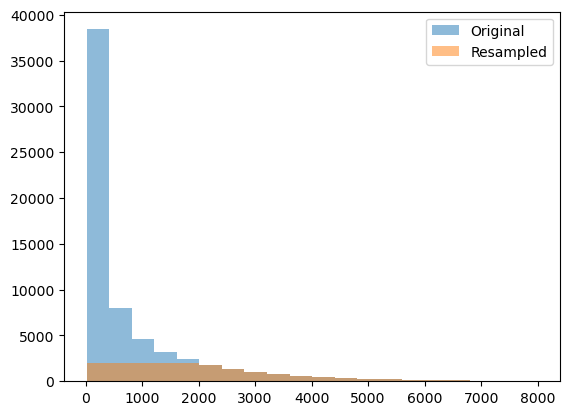

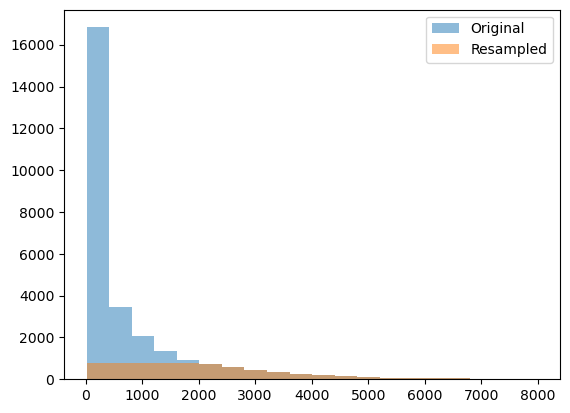

In [12]:
import matplotlib.pyplot as plt

plt.hist(y_train[:, 3], bins=20, alpha=0.5, label="Original")
plt.hist(y_train_resampled[:, 3], bins=20, alpha=0.5, label="Resampled")
plt.legend()
plt.show()

plt.hist(y_test[:, 3], bins=20, alpha=0.5, label="Original")
plt.hist(y_test_resampled[:, 3], bins=20, alpha=0.5, label="Resampled")
plt.legend()
plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import resample

# # 假设 y_train[:, 3] 是第四个特征
# y_train_fourth = y_train[:, 3]

# # 分箱（假设我们分为10个区间，可以根据需要调整）
# bins = np.linspace(np.min(y_train_fourth), np.max(y_train_fourth), num=11)  # 10个区间
# bin_indices = np.digitize(y_train_fourth, bins)

# # 创建一个 DataFrame 来存储每个区间的样本
# df = pd.DataFrame({'X': list(X_train), 'y': list(y_train), 'bin': bin_indices})

# # 计算每个区间的样本数
# bin_counts = df['bin'].value_counts()
 
# # 找到最大样本数
# max_count = bin_counts.max()

# # 创建一个新的列表来存储重采样后的数据
# resampled_X, resampled_y = [], []

# for bin_value in bin_counts.index:
#     # 获取当前区间的所有样本
#     bin_samples = df[df['bin'] == bin_value]
    
#     # 如果该区间的样本少于最大样本数，进行过采样
#     if len(bin_samples) < max_count:
#         bin_samples = resample(bin_samples, replace=True, n_samples=max_count, random_state=42)
#     # 如果该区间的样本多于最大样本数，进行欠采样
#     elif len(bin_samples) > max_count:
#         bin_samples = resample(bin_samples, replace=False, n_samples=max_count, random_state=42)
    
#     # 添加到重采样后的数据中
#     resampled_X.append(bin_samples['X'].to_list())
#     resampled_y.append(bin_samples['y'].to_list())

# # 将重采样后的数据合并
# resampled_X = np.concatenate(resampled_X, axis=0)
# resampled_y = np.concatenate(resampled_y, axis=0)

# # 检查重采样后的结果
# print("Resampled X_train shape:", resampled_X.shape)
# print("Resampled y_train shape:", resampled_y.shape)


Resampled X_train shape: (610731, 10, 4)
Resampled y_train shape: (610731, 4)


In [9]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (427511, 10, 4)
X_test.shape (183220, 10, 4)
y_train.shape (427511, 4)
y_test.shape (183220, 4)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import resample

# # 假设 y_train[:, 3] 是第四个特征
# y_train_fourth = y_train[:, 3]

# # 步骤 1: 去掉 y 的第四个特征大于 2500 的样本
# mask = y_train_fourth <= 2500
# X_train_filtered = X_train[mask]
# y_train_filtered = y_train[mask]

# # 步骤 2: 分箱
# bins = np.linspace(np.min(y_train_filtered[:, 3]), np.max(y_train_filtered[:, 3]), num=11)  # 10个区间
# bin_indices = np.digitize(y_train_filtered[:, 3], bins)

# # 步骤 3: 创建一个 DataFrame 来存储每个区间的样本
# df = pd.DataFrame({'X': list(X_train_filtered), 'y': list(y_train_filtered), 'bin': bin_indices})

# # 计算每个区间的样本数
# bin_counts = df['bin'].value_counts()

# # 找到最小的样本数（最小样本数用于欠采样）
# min_count = bin_counts.min()

# # 创建一个新的列表来存储重采样后的数据
# resampled_X, resampled_y = [], []

# for bin_value in bin_counts.index:
#     # 获取当前区间的所有样本
#     bin_samples = df[df['bin'] == bin_value]
    
#     # 进行欠采样：随机选择 min_count 个样本
#     bin_samples = resample(bin_samples, replace=False, n_samples=min_count, random_state=42)
    
#     # 添加到重采样后的数据中
#     resampled_X.append(bin_samples['X'].to_list())
#     resampled_y.append(bin_samples['y'].to_list())

# # 将重采样后的数据合并
# resampled_X = np.concatenate(resampled_X, axis=0)
# resampled_y = np.concatenate(resampled_y, axis=0)

# # 检查重采样后的结果
# print("Resampled X_train shape:", resampled_X.shape)
# print("Resampled y_train shape:", resampled_y.shape)

Resampled X_train shape: (55, 10, 4)
Resampled y_train shape: (55, 4)


### 数据形状处理

In [ ]:
# X_train[:, -1, -1] = 0
# X_test[:, -1, -1] = 0

In [39]:
X_train = X_train_resampled
y_train = y_train_resampled

X_test = X_test_resampled
y_test = y_test_resampled

In [40]:
# 将x_train和y_train接起来
y_train_expanded = np.expand_dims(y_train, axis=1)  # 将 y_train 从 (n, 4) 转换为 (n, 1, 4)
train_data = np.concatenate((X_train, y_train_expanded), axis=1)

# 将x_test和y_test接起来
y_test_expanded = np.expand_dims(y_test, axis=1)  # 将 y_test 从 (n, 4) 转换为 (n, 1, 4)
test_data = np.concatenate((X_test, y_test_expanded), axis=1)


train_data.shape, test_data.shape

((17101, 11, 4), (7102, 11, 4))

In [41]:
train_data[:, -1, -1] = 0
test_data[:, -1, -1] = 0

X_train = train_data
X_test = test_data

y_train = y_train[:, 3]
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train.shape, y_test.shape

((17101, 1), (7102, 1))

### 特征处理

In [50]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler_3 = MinMaxScaler()
X_train_features_3 = scaler_3.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler_3.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# # 标准化前三个特征
# scaler = StandardScaler()
# X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
# X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 线性变化第四个特征 
# scaler = 1000
# X_train_feature_4 = X_train_feature_4/scaler
# X_test_feature_4 = X_test_feature_4/scaler


# 标准化第四个特征
# scaler_4 = StandardScaler()
# X_train_feature_4 = scaler_4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
# X_test_feature_4 = scaler_4.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)


# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (n_samples, 10, 4)
print(X_test_processed.shape)   # 应该是 (n_samples, 10, 4)

# 对第四个特征取对数（确保数值大于0）
# y_train_processed = y_train
# y_test_processed = y_test

y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)

# 线性变化第四个特征 
# y_train_processed = y_train/scaler
# y_test_processed = y_test/scaler

# 对目标变量进行标准化
# scaler_y = StandardScaler()
# y_train_processed = scaler_y.fit_transform(y_train)  # 直接对y进行标准化
# y_test_processed = scaler_y.transform(y_test)  # 使用训练集的标准化参数处理测试集


# 检查结果
print(y_train_processed.shape)  # 应该是 (n_samples, 4)
print(y_test_processed.shape)   # 应该是 (n_samples, 4)

(17101, 11, 4)
(7102, 11, 4)
(17101, 1)
(7102, 1)


In [64]:
# Box-Cox 变换
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# 假设你的训练集和测试集是 X_train 和 X_test，y_train 和 y_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler = MinMaxScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征进行 Box-Cox 变换
# 由于 Box-Cox 变换要求数据为正数，确保没有零或负数
X_train_feature_4_transformed, lambda_train = stats.boxcox(X_train_feature_4.flatten()+1e-6)
X_test_feature_4_transformed = (X_test_feature_4.flatten()+1e-6 ** lambda_train - 1) / lambda_train if lambda_train != 0 else np.log(X_test_feature_4.flatten()+1e-6)

# 重新调整为原始的形状
X_train_feature_4_transformed = X_train_feature_4_transformed.reshape(X_train_feature_4.shape)
X_test_feature_4_transformed = X_test_feature_4_transformed.reshape(X_test_feature_4.shape)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4_transformed[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4_transformed[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (n_samples, 10, 4)
print(X_test_processed.shape)   # 应该是 (n_samples, 10, 4)

# 对目标值 y_train 和 y_test 进行 Box-Cox 变换
y_train_transformed, lambda_y = stats.boxcox(y_train.flatten())  # 假设 y_train 是形状 (n_samples, 1)
y_test_transformed = (y_test.flatten() ** lambda_y - 1) / lambda_y if lambda_y != 0 else np.log(y_test.flatten())

# 重新调整为原始的形状
y_train_processed = y_train_transformed.reshape(y_train.shape)
y_test_processed = y_test_transformed.reshape(y_test.shape)

# # # 对目标值（y_train 和 y_test）进行标准化
# scaler_y = MinMaxScaler()
# y_train_processed = scaler_y.fit_transform(y_train_transformed)
# y_test_processed = scaler_y.transform(y_test_transformed)

# 检查结果
print(y_train_processed.shape)  # 应该是 (n_samples, 4)
print(y_test_processed.shape)   # 应该是 (n_samples, 4)

(613859, 10, 4)
(263083, 10, 4)


ValueError: Data must be positive.

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1215179, 11, 4), (524954, 11, 4), (1215179, 1), (524954, 1))

In [ ]:
X_test_processed[0], y_test_processed[0], X_train_processed[0], y_train_processed[0]

(array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.09861262e+00],
        [ 1.00000000e+00,  1.00000000e+00,  2.00000000e-01,
          2.89037181e+00],
        [ 0.00000000e+00,  1.11111111e-01,  0.00000000e+00,
          4.15888310e+00],
        [ 0.00000000e+00,  1.11111111e-01,  2.00000000e-01,
          9.99999500e-07],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
          2.83321340e+00],
        [ 0.00000000e+00,  0.00000000e+00,  3.00000000e-01,
          2.07944167e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
          9.99999500e-07],
        [ 0.00000000e+00,  0.00000000e+00,  3.00000000e-01,
          3.46573593e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
          9.99999500e-07],
        [ 0.00000000e+00,  0.00000000e+00,  3.00000000e-01,
          6.93147681e-01],
        [ 0.00000000e+00,  0.00000000e+00,  5.00000000e-01,
         -1.38155106e+01]]),
 array([1.60943811]),
 array([[  1.      

In [51]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train))
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))
# train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))
# test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test))

In [ ]:
X_train_processed[100], y_train_processed[0], X_test_processed[0], y_test_processed[0]

(array([[  0.5       ,   0.        ,   0.6       ,   4.70953021],
        [  0.5       ,   0.        ,   0.8       ,   3.36729586],
        [  0.5       ,   0.        ,   0.6       ,   1.79175964],
        [  0.5       ,   0.        ,   0.8       ,   3.68887948],
        [  0.        ,   0.        ,   0.3       ,   3.63758619],
        [  0.5       ,   0.        ,   0.9       ,   4.83628191],
        [  0.        ,   0.        ,   0.5       ,   5.50533154],
        [  0.5       ,   0.        ,   0.9       ,   0.69314768],
        [  0.        ,   0.        ,   0.7       ,   0.69314768],
        [  0.5       ,   0.        ,   0.9       ,   1.94591029],
        [  0.        ,   0.        ,   0.4       , -13.81551056]]),
 array([ 9.99999500e-07,  9.99999500e-07, -1.38155106e+01,  9.99999500e-07]),
 array([[  1.        ,   1.        ,   0.        ,   4.46590813],
        [  1.        ,   1.        ,   0.2       ,   2.19722469],
        [  0.        ,   0.22222222,   0.        ,   1.0986126

In [52]:
X_train_processed.shape, y_train_processed.shape, X_test_processed.shape, y_test_processed.shape

((510224, 11, 4), (510224, 1), (223135, 11, 4), (223135, 1))

### 数据分布图

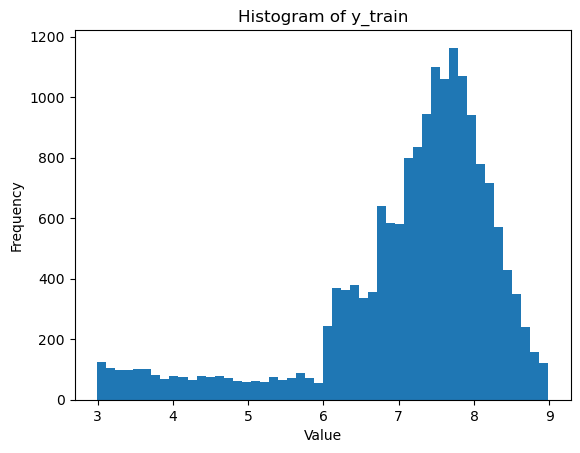

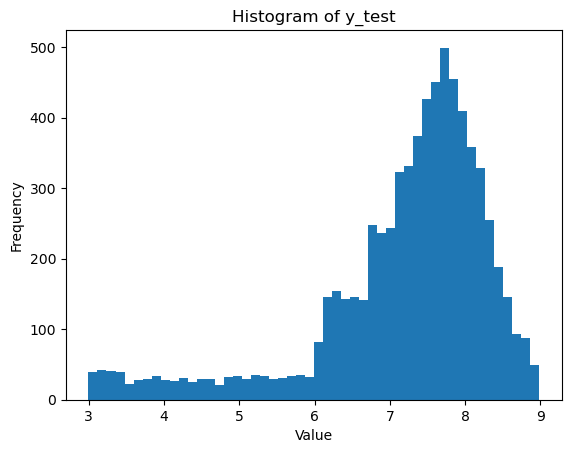

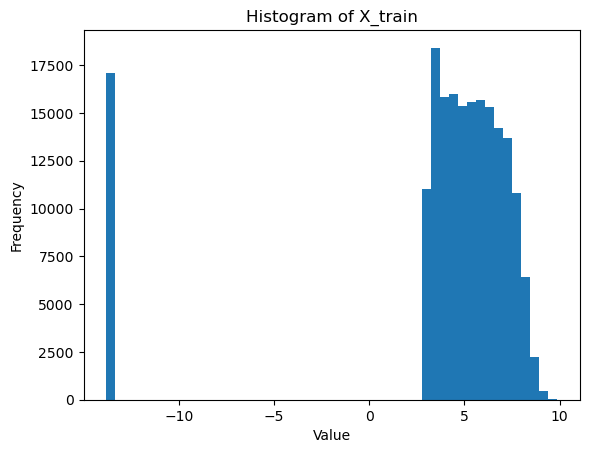

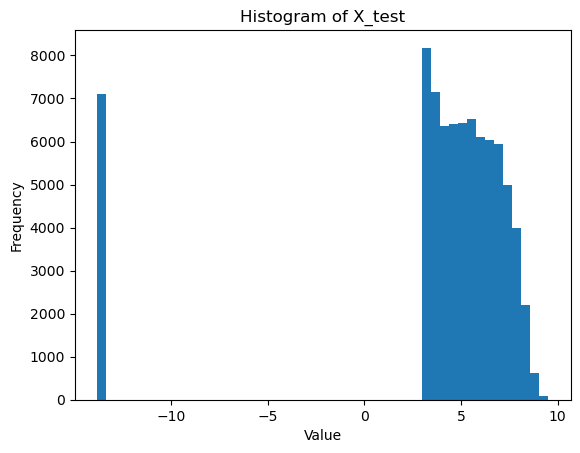

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用Matplotlib绘制直方图
plt.hist(y_train_processed.flatten(), bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# 使用Matplotlib绘制直方图
plt.hist(y_test_processed.flatten(), bins=50)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 使用Matplotlib绘制直方图
plt.hist(X_train_processed[:, :, -1].flatten(), bins=50)
plt.title('Histogram of X_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# 使用Matplotlib绘制直方图
plt.hist(X_test_processed[:, :, -1].flatten(), bins=50)
plt.title('Histogram of X_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


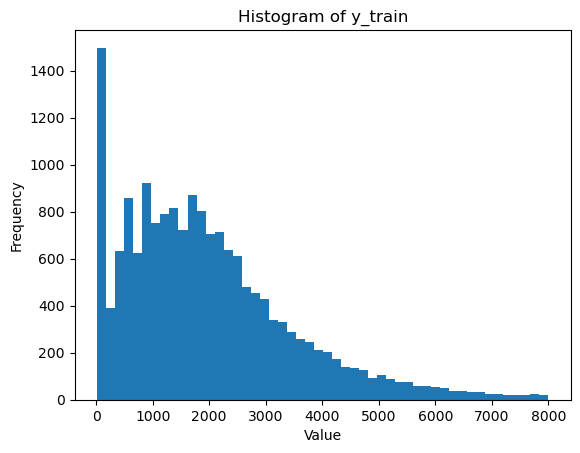

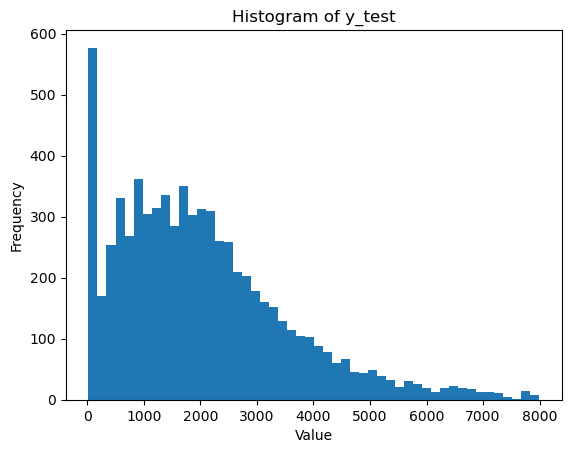

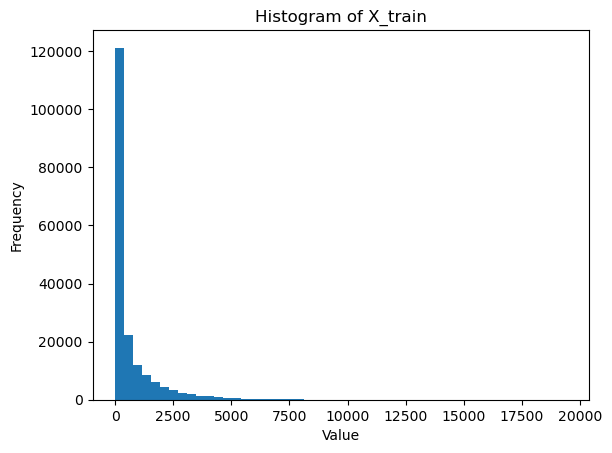

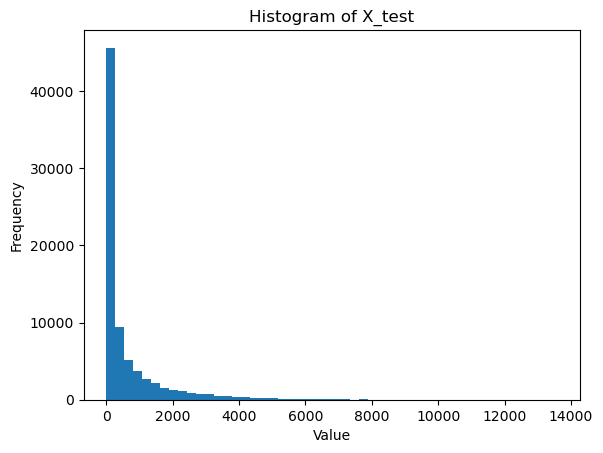

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用Matplotlib绘制直方图
plt.hist(y_train.flatten(), bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# 使用Matplotlib绘制直方图
plt.hist(y_test.flatten(), bins=50)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 使用Matplotlib绘制直方图
plt.hist(X_train[:, :, -1].flatten(), bins=50)
plt.title('Histogram of X_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
# 使用Matplotlib绘制直方图
plt.hist(X_test[:, :, -1].flatten(), bins=50)
plt.title('Histogram of X_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


### 模型


In [22]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, epsilon=1e-6):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        # 计算绝对误差
        loss = torch.abs(y_pred - y_true)
        
        # 计算焦点损失
        focal_loss = self.alpha * (1 - loss / (torch.abs(y_true) + self.epsilon))**self.gamma * loss
        return focal_loss.mean()


In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :] # [input_window, batch size, embed dim]

class TransAm(nn.Module):
    def __init__(self, series_dim, feature_size = 80, num_layers=3, dropout=0.5):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.input_embedding = nn.Linear(series_dim, feature_size)
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size, feature_size//2)
        self.out = nn.Linear(feature_size//2, series_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        # 将解码器的权重初始化为均匀分布的随机值，范围在 [−0.1,0.1] 之间
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        src = self.input_embedding(src)
        src = self.pos_encoder(src) # [input_window, batch_size, feature_size]
        en_output = self.transformer_encoder(src, self.src_mask) 
        de_output = self.decoder(en_output) # [input_window, batch_size, feature_size//2]
        out_put = self.out(de_output[-output_window:,:,:])
        return out_put # [output_window, batch_size, series_dim]

    def _generate_square_subsequent_mask(self, sz):
        '''
        生成一个上三角掩码矩阵，防止模型在预测时看到未来时间步的数据。若 sz = 4 则生成：
        [[0.0,   -inf,  -inf,  -inf],
        [0.0,    0.0,  -inf,  -inf],
        [0.0,    0.0,   0.0,  -inf],
        [0.0,    0.0,   0.0,   0.0]]
        '''
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    

In [ ]:
# 模型
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
        self.h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        self.c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    def forward(self, x):
        # Initialize hidden state with zeros
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # # Initialize cell state
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
        
# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 训练

In [54]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 1024
num_layers = 8
batch_size = 256
sequence_length = 11

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 4
num_classes= 1
model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
# model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.4, num_heads=8)
# print('num_classes:', num_classes)

model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() # FocalLoss(alpha=0.25, gamma=2) #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.4, patience=10, min_lr=1e-7, verbose=True)

# 训练模型
num_epochs = 500
best_loss = np.inf
early_stopping_patience = 50
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if val_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        if best_loss - val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

    # 保存最好的模型
    torch.save(best_model, '../model/lstm1024_l8_T1500c20rsntMax_sst11.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

NameError: name 'x' is not defined

In [32]:
# 评估预测结果
model.eval()
train_targets = []
train_predictions = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        train_predictions.append(outputs.cpu().numpy())
        train_targets.append(y_batch.cpu().numpy()) 

train_predictions = np.concatenate(train_predictions)
train_targets = np.concatenate(train_targets) 
# print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(train_targets, train_predictions)))

Test RMSE: 1.2540405


In [33]:
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

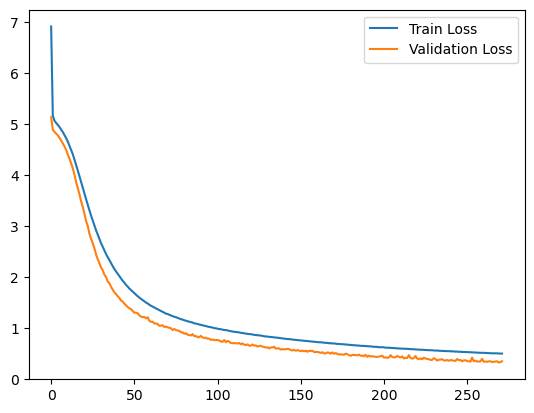

In [34]:
# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

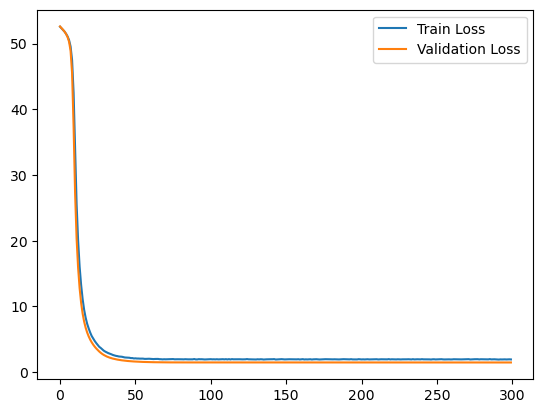

In [82]:
# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

### Evaluation

In [92]:
# 评估预测结果
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="test", unit="batch")):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length+1, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

test: 100%|██████████| 435/435 [00:00<00:00, 703.23batch/s]


In [ ]:
# 数据转回原始尺度
predictions = scaler_y.inverse_transform(predictions)
targets = scaler_y.inverse_transform(targets)

In [24]:
# 数据转回非log
predictions = np.exp(predictions)
targets = np.exp(targets)

In [186]:
predictions[1], targets[1]

(array([2.61678], dtype=float32), array([1.7917596], dtype=float32))

In [92]:
predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [ ]:
# predictions_s = predictions
# targets_s = targets
# predictions = predictions[:, :-1]
# targets = targets[:, :-1]

# predictions.shape, targets.shape

((264803, 3), (264803, 3))

#### 指标

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 1.1849532
Mean Squared Error (MSE): 1.4041142
Mean Absolute Error (MAE): 0.852647
R^2 Score: 0.0008793104838581423


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 0.56842613
Mean Squared Error (MSE): 0.3231083
Mean Absolute Error (MAE): 0.34290752
R^2 Score: 0.9488135268164927


In [98]:
#保存预测结果
np.savez('../results/mul_T1500c20sa_sst11_log_test.npz', arr1=targets, arr2=predictions)

In [149]:
# 反向对数变换：将对数变换的值恢复到原始值
predictions = np.exp(predictions) - 1e-6  # 减去加的常数（避免log(0)）
targets = np.exp(targets) - 1e-6

# 反向标准化：将标准化的数据恢复到原始尺度
# predictions = scaler_y.inverse_transform(prediction_exp)
# targets = scaler_y.inverse_transform(target_exp)

# 检查结果
print(predictions.shape)  # 应该是 (n_samples, 4)
print(targets.shape)      # 应该是 (n_samples, 4)

(27812, 1)
(27812, 1)


In [66]:
# 反向标准化：将标准化的数据恢复到原始尺度
predictions = scaler_y.inverse_transform(predictions)
targets = scaler_y.inverse_transform(targets)

# # 反向对数变换：将对数变换的值恢复到原始值
# predictions = np.exp(predictions) - 1e-6  # 减去加的常数（避免log(0)）
# targets = np.exp(targets) - 1e-6

# 检查结果
print(predictions.shape)  # 应该是 (n_samples, 4)
print(targets.shape)      # 应该是 (n_samples, 4)

(116060, 1)
(116060, 1)


In [ ]:
# 反向标准化：将标准化的数据恢复到原始尺度
predictions = scaler_y.inverse_transform(predictions)
targets = scaler_y.inverse_transform(targets)

# # 反向对数变换：将对数变换的值恢复到原始值
# predictions = np.exp(predictions) - 1e-6  # 减去加的常数（避免log(0)）
# targets = np.exp(targets) - 1e-6

# 检查结果
print(predictions.shape)  # 应该是 (n_samples, 4)
print(targets.shape)      # 应该是 (n_samples, 4)

In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

#### 画图

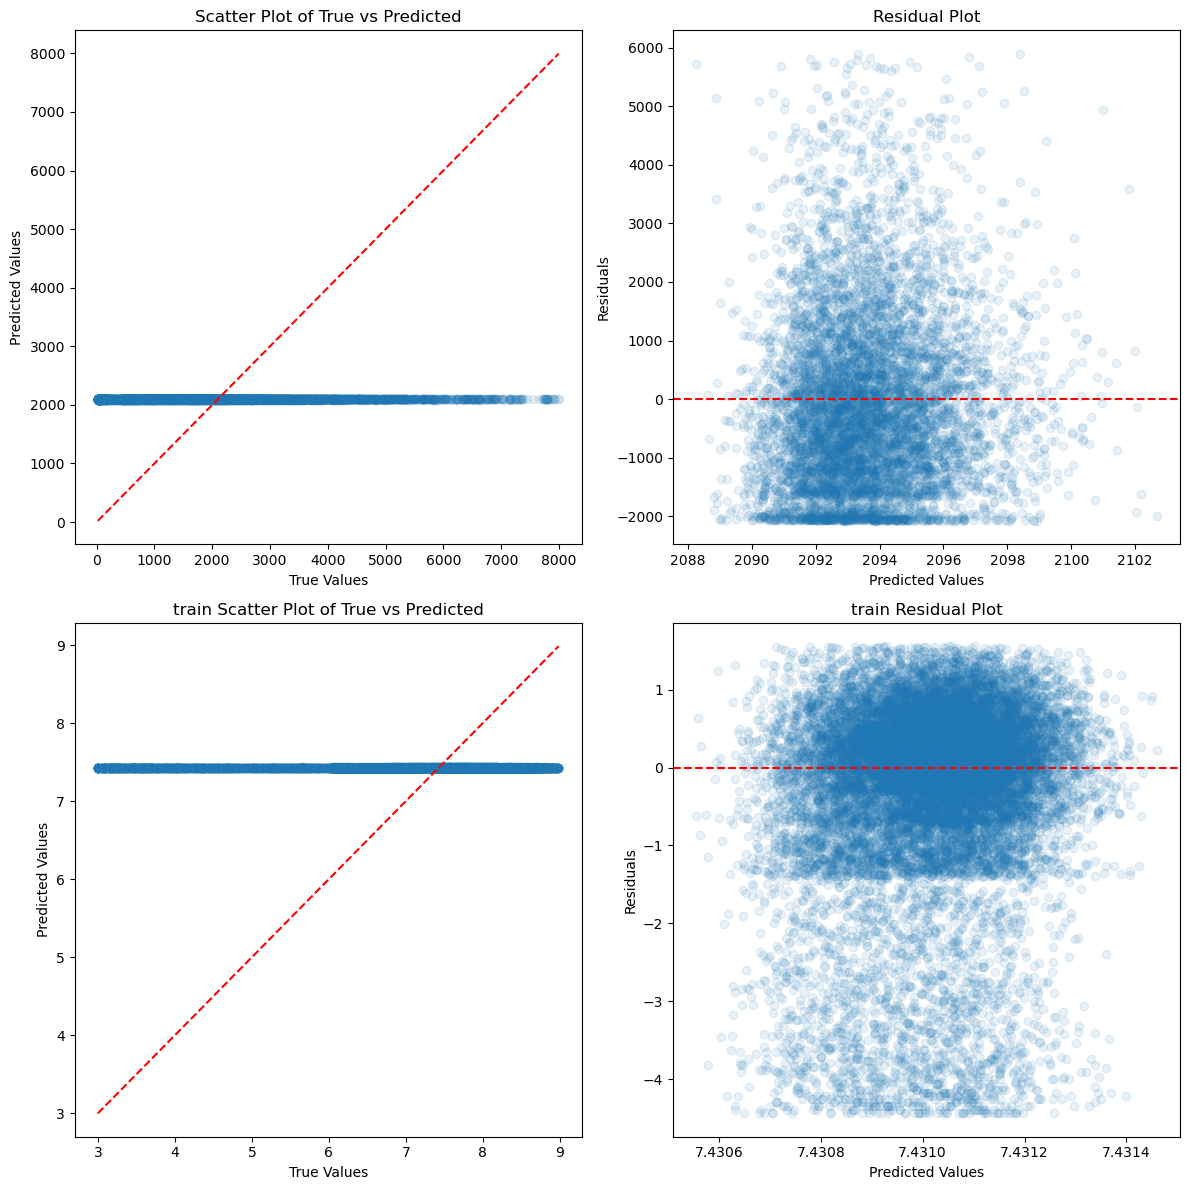

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 假设 y_test 是真实值，predictions 是预测值
residuals = targets - predictions
residuals = residuals.flatten()  # 将 residuals 转换为一维数组
residuals_train = train_targets - train_predictions
residuals_train = residuals_train.flatten()  # 将 residuals 转换为一维数组

# 创建 2x2 的子图（一个 2 行 2 列的布局）
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 绘制散点图
axes[0, 0].scatter(targets, predictions, alpha=0.1)
axes[0, 0].plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Scatter Plot of True vs Predicted')

# 绘制残差图
axes[0, 1].scatter(predictions, residuals, alpha=0.1)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# # 绘制误差分布图
# axes[1, 0].hist(residuals, bins=30, density=True, alpha=0.6, color='g')
# axes[1, 0].set_xlabel('Residuals')
# axes[1, 0].set_ylabel('Frequency')
# axes[1, 0].set_title('Error Distribution')

# # 绘制 Q-Q 图
# stats.probplot(residuals, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title('Q-Q Plot')

# 绘制散点图
axes[1, 0].scatter(train_targets, train_predictions, alpha=0.1)
axes[1, 0].plot([min(train_targets), max(train_targets)], [min(train_targets), max(train_targets)], color='red', linestyle='--')
axes[1, 0].set_xlabel('True Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].set_title('train Scatter Plot of True vs Predicted')

# 绘制残差图
axes[1, 1].scatter(train_predictions, residuals_train, alpha=0.1)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('train Residual Plot')

# 调整布局
plt.tight_layout()
plt.show()


In [83]:
max(y_test)

array([16515])

IndexError: index 1 is out of bounds for axis 1 with size 1

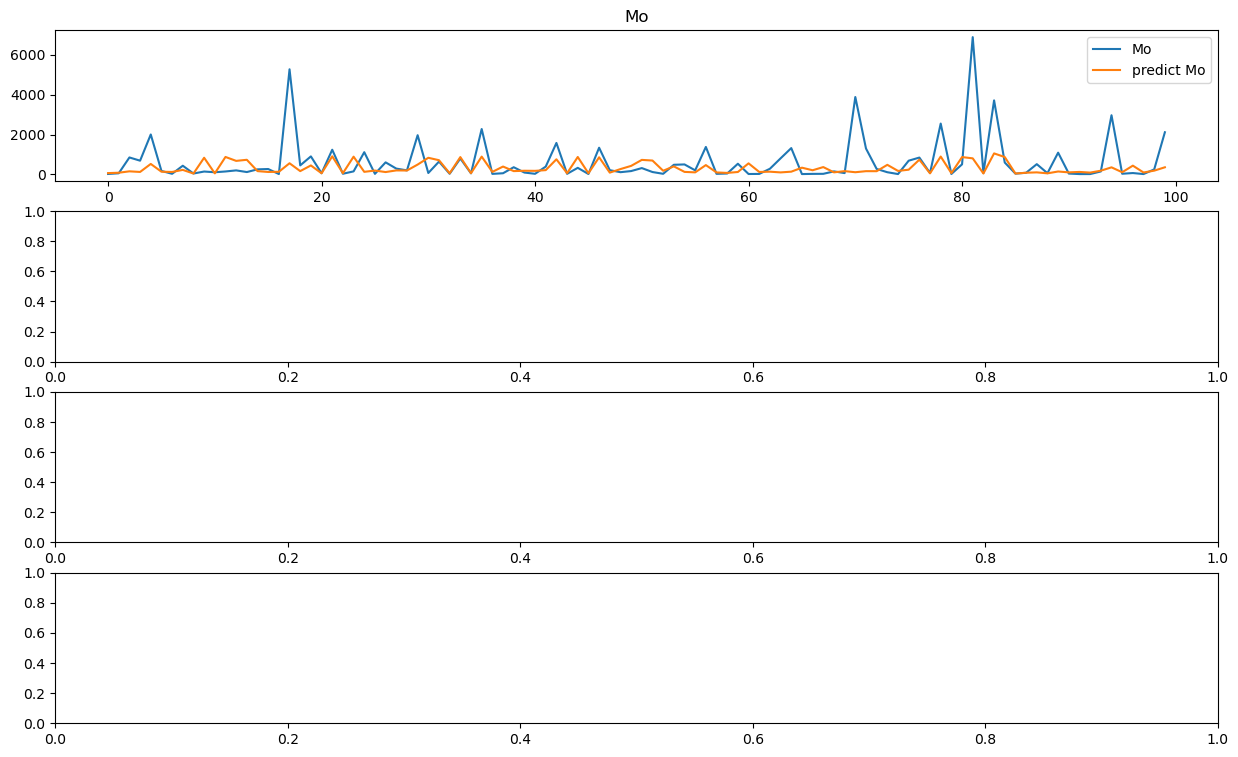

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end]
t1 = t_round[start:end]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:], label='Mo')
axs[0].plot(p1[:], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

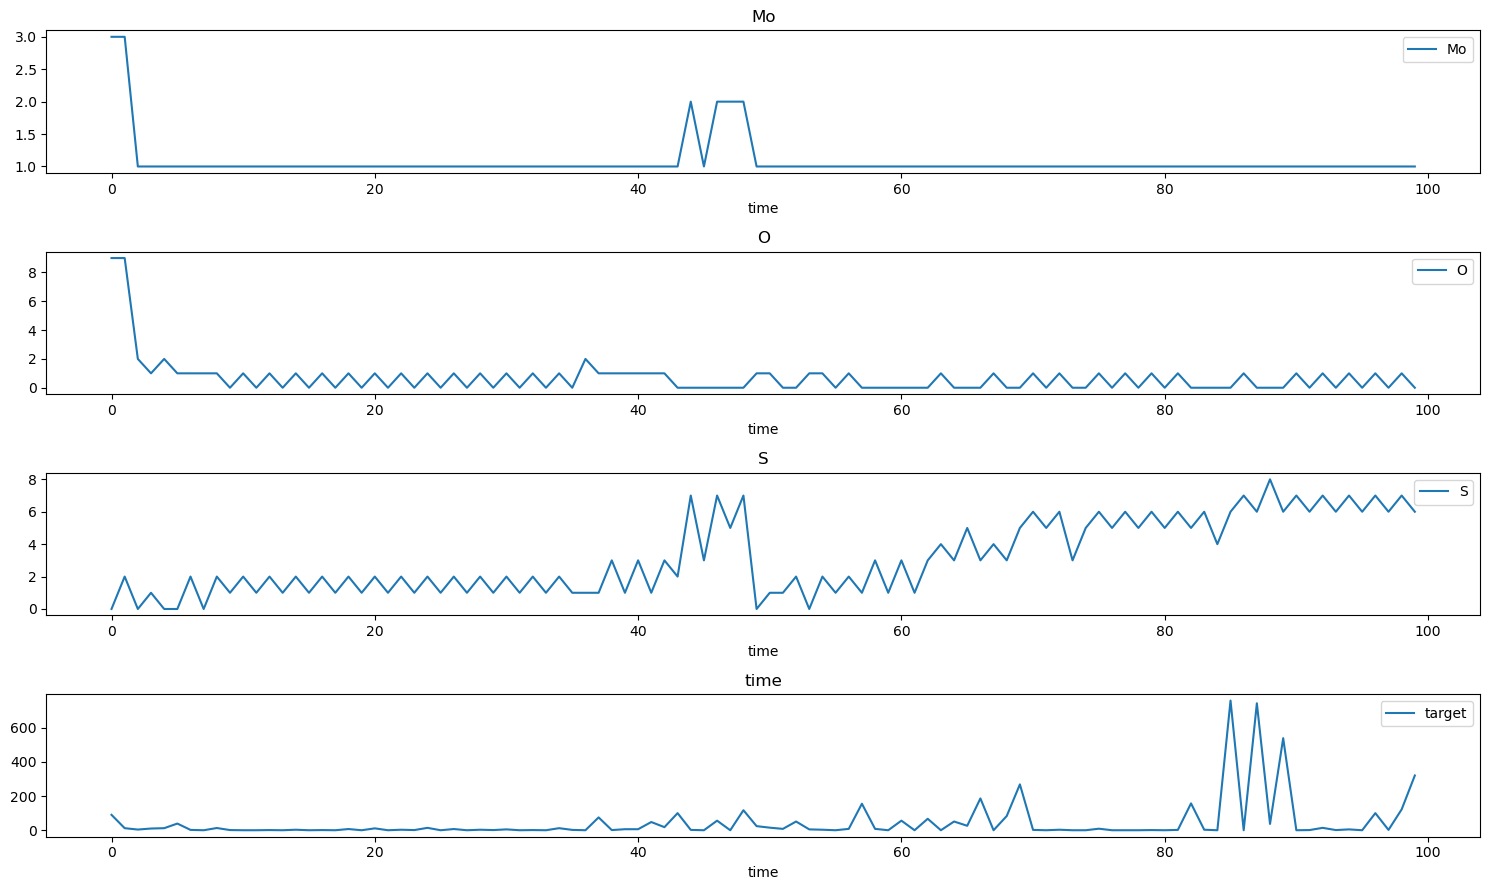

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [1]:
import numpy as np
ss = np.load('../results/mul_T900_ss.npz')
ss_targets = ss['arr1']
ss_predictions = ss['arr2']

sts = np.load('../results/mul_T900_sts.npz')
sts_targets = sts['arr1']
sts_predictions = sts['arr2']

stst = np.load('../results/mul_T900_stst.npz')
stst_targets = stst['arr1']
stst_predictions = stst['arr2']

NameError: name 'ss_predictions' is not defined

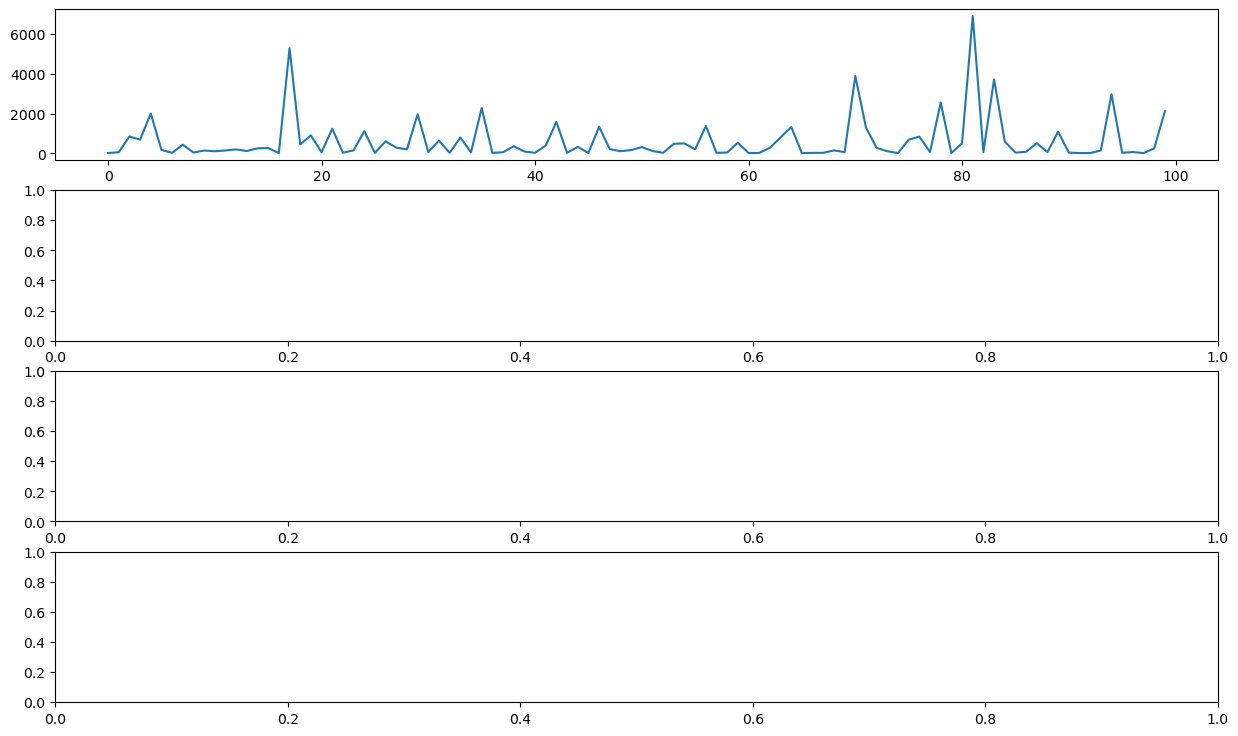

In [116]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = targets.round()  # stst_targets
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(ss_predictions[start:end, 0], label='ss_predictions')
axs[0].plot(sts_predictions[start:end, 0], label='sts_predictions')
axs[0].plot(stst_predictions[start:end, 0], label='stst_predictions')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(ss_predictions[start:end, 1], label='ss_predictions')
axs[1].plot(sts_predictions[start:end, 1], label='sts_predictions')
axs[1].plot(stst_predictions[start:end, 1], label='stst_predictions')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(ss_predictions[start:end, 2], label='ss_predictions')
axs[2].plot(sts_predictions[start:end, 2], label='sts_predictions')
axs[2].plot(stst_predictions[start:end, 2], label='stst_predictions')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# # axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')